# Aerial Semantic Segmentation Drone

## [Data Link](https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset)

## Developed By: Eng. Waleed Shaban

## Developed On Kaggle Notebook

### Import Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import utils
from keras import backend as keras
from tensorflow.keras.preprocessing.image import load_img
import random
import warnings


random.seed(42)
np.random.seed(42)
utils.set_random_seed(42)
warnings.filterwarnings('ignore')

### Explore Data

In [2]:
data_path = '/kaggle/input/semantic-drone-dataset'
org_imgs_path = os.path.join(data_path, 'dataset', 'semantic_drone_dataset', 'original_images')
masks_path = os.path.join(data_path, 'RGB_color_image_masks', 'RGB_color_image_masks')
print(f"Numper of images: {len(os.listdir(org_imgs_path))}")
print(f"Numper of masks: {len(os.listdir(masks_path))}")

Numper of images: 400
Numper of masks: 400


### Show Samples from data

In [3]:
image_name = os.listdir(org_imgs_path)[0]
org_img = cv2.imread(os.path.join(org_imgs_path, image_name))
org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(os.path.join(masks_path, image_name.replace('.jpg', '.png')))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

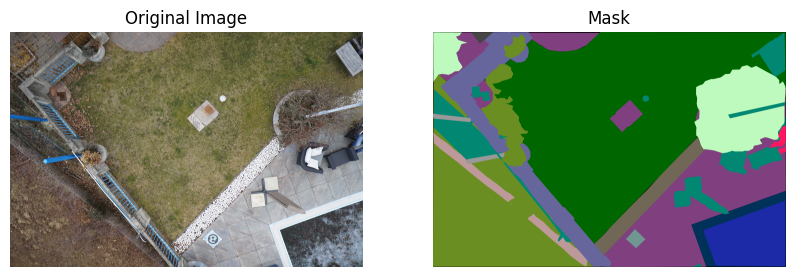

In [4]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(org_img)
plt.axis('off')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.axis('off')
plt.title('Mask')
plt.show()

### Read Classes Csv



In [5]:
csv_path = os.path.join(data_path, 'class_dict_seg.csv')
classes = pd.read_csv(csv_path)
classes

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [6]:
n_classes = len(classes)
n_classes

24

### Convert Csv file to dictionairy with values

In [7]:
cls2rgb = {cl:list(values) for cl, values in zip(classes['name'], classes.iloc[:,1:].values)}
cls2rgb

{'unlabeled': [0, 0, 0],
 'paved-area': [128, 64, 128],
 'dirt': [130, 76, 0],
 'grass': [0, 102, 0],
 'gravel': [112, 103, 87],
 'water': [28, 42, 168],
 'rocks': [48, 41, 30],
 'pool': [0, 50, 89],
 'vegetation': [107, 142, 35],
 'roof': [70, 70, 70],
 'wall': [102, 102, 156],
 'window': [254, 228, 12],
 'door': [254, 148, 12],
 'fence': [190, 153, 153],
 'fence-pole': [153, 153, 153],
 'person': [255, 22, 96],
 'dog': [102, 51, 0],
 'car': [9, 143, 150],
 'bicycle': [119, 11, 32],
 'tree': [51, 51, 0],
 'bald-tree': [190, 250, 190],
 'ar-marker': [112, 150, 146],
 'obstacle': [2, 135, 115],
 'conflicting': [255, 0, 0]}

### mask labels adjustment

In [8]:
def adjust_mask(mask, flat=False):

    semantic_map = []
    for colour in list(cls2rgb.values()):
        equality = np.equal(mask, colour)# 256x256x3 with True or False
        class_map = np.all(equality, axis = -1)# 256x256 If all True, then True, else False
        semantic_map.append(class_map)# List of 256x256 arrays, map of True for a given found color at the pixel, and False otherwise.
    semantic_map = np.stack(semantic_map, axis=-1)# 256x256x32 True only at the found color, and all False otherwise.
    if flat:
        semantic_map = np.reshape(semantic_map, (-1,256*256))

    return np.float32(semantic_map)# convert to numbers

In [9]:
org_img.shape

(4000, 6000, 3)

In [10]:
mask.shape

(4000, 6000, 3)

In [11]:
new_mask = adjust_mask(mask)
new_mask.shape

(4000, 6000, 24)

### Prepare for reverse mapping



> We are checking if we performed mapping correctly.



> Also, We will need it later in prediction.



In [12]:
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}
idx2rgb

{0: array([0, 0, 0]),
 1: array([128,  64, 128]),
 2: array([130,  76,   0]),
 3: array([  0, 102,   0]),
 4: array([112, 103,  87]),
 5: array([ 28,  42, 168]),
 6: array([48, 41, 30]),
 7: array([ 0, 50, 89]),
 8: array([107, 142,  35]),
 9: array([70, 70, 70]),
 10: array([102, 102, 156]),
 11: array([254, 228,  12]),
 12: array([254, 148,  12]),
 13: array([190, 153, 153]),
 14: array([153, 153, 153]),
 15: array([255,  22,  96]),
 16: array([102,  51,   0]),
 17: array([  9, 143, 150]),
 18: array([119,  11,  32]),
 19: array([51, 51,  0]),
 20: array([190, 250, 190]),
 21: array([112, 150, 146]),
 22: array([  2, 135, 115]),
 23: array([255,   0,   0])}

### Reverse Mapping

In [13]:
def map_class_to_rgb(p):

    return idx2rgb[p[0]]

rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(new_mask, axis=-1), -1))
rgb_mask.shape

(4000, 6000, 3)

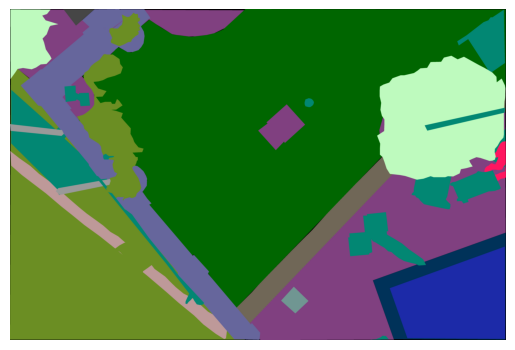

In [14]:
plt.imshow(rgb_mask)
plt.axis('off')
plt.show()

### Free Ram

In [15]:
rgb_mask = 0
new_mask = 0
org_img = 0
mask = 0

In [16]:
imgs_name = [path.replace('.jpg', '') for path in os.listdir(org_imgs_path)]

### Check existance of all images

In [17]:
for img_name in imgs_name:
    if not os.path.exists(os.path.join(masks_path, img_name+'.png')):
        print(img_name)
    if not os.path.exists(os.path.join(org_imgs_path, img_name+'.jpg')):
        print(img_name)

### Load the dataset 

In [18]:
data_gen_args = dict(rescale=1./255,
                    validation_split = 0.2)
mask_gen_args = dict(validation_split = 0.2)
seed = 1
batch_sz = 4

In [19]:
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**mask_gen_args)

In [20]:
imgs_path = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset'
masks_path = '/kaggle/input/semantic-drone-dataset/RGB_color_image_masks'
image_generator = image_datagen.flow_from_directory(
    imgs_path,
    class_mode=None,
    classes=['original_images'],
    seed=seed,
    batch_size=batch_sz,
    target_size=(256,256),
    subset='training')

mask_generator = mask_datagen.flow_from_directory(
    masks_path,
    classes=['RGB_color_image_masks'],
    class_mode=None,
    seed=seed,
    color_mode='rgb',
    batch_size=batch_sz,
    target_size=(256,256),
    subset='training')

train_generator = zip(image_generator, mask_generator)

Found 320 images belonging to 1 classes.
Found 320 images belonging to 1 classes.


In [21]:
val_image_generator = image_datagen.flow_from_directory(
    imgs_path,
    class_mode=None,
    classes=['original_images'],
    seed=seed,
    batch_size=batch_sz,
    target_size=(256,256),
    subset='validation')

val_mask_generator = mask_datagen.flow_from_directory(
    masks_path,
    classes=['RGB_color_image_masks'],
    class_mode=None,
    seed=seed,
    color_mode='rgb',
    batch_size=batch_sz,
    target_size=(256,256),
    subset='validation')

val_generator = zip(val_image_generator, val_mask_generator)

Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.


In [22]:
n_train_samples = 320
n_test_samples = 80

In [23]:
def train_generator_fn():

    for (img,mask) in train_generator:
        new_mask = adjust_mask(mask)
        yield (img,new_mask)

In [24]:
def val_generator_fn():

    for (img,mask) in val_generator:
        new_mask = adjust_mask(mask)
        yield (img,new_mask)

In [25]:
x, y = next(train_generator_fn())
x.shape, y.shape

((4, 256, 256, 3), (4, 256, 256, 24))

## Model
__U-Net__

We will investigate a famous model called U-Net

![U Net](https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/u-net-architecture.png)

It uses the same architecture as the encoder decoder. However it adds a well known trick called skip connections. Skip connections was first introduced in ResNet. It roots also in the recurrent neural network literature with LSTMs and GRUs.

The main issue skip connections is trying to solve is the very deep nets. Or in recurrence, the very long time dependency (back prop through time). With the increased network depth, we face the problem of vanishing gradients, due to the chain rule effect, the gradients are reduced a lot that they could vanish, and no weight updates is possible.

Skip connections enables an alternative path to the gradients:

`x2=f(x1) + x1`

This is called a residual block

![Res](https://qph.fs.quoracdn.net/main-qimg-93cef3d493d15b211aba8db3fd536b82)

In this way, if the gradient of F(x) vanished, we have an identity gradient of x that can still flow.


Also, U-Net uses upsampling as we discussed earlier.




In [26]:
def unet(n_classes, pretrained_weights = None,input_size = (256,256,3), flat=False, ohe=True):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    x = UpSampling2D(size = (2,2))(drop5)
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv10 = Conv2D(n_classes, (1,1), activation = 'softmax')(conv9)
    conv10 = Conv2D(n_classes, (1,1), padding='same')(conv9)
    if flat:
        output_layer = Reshape((256*256,n_classes))(conv10)
    else:
        output_layer = conv10
    output_layer = Activation('softmax')(output_layer)


    model = Model(inputs = inputs, outputs = output_layer)

    if ohe:
        model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    else:
        model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model



In [27]:
model = unet(n_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_9[0][0]  

 Total params: 31,033,240 (118.38 MB)

 Trainable params: 31,033,240 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [28]:
view = 0
epochs = 100
steps_per_epoch = (n_train_samples // batch_sz) + 30
validation_steps = n_test_samples // batch_sz

In [29]:
save_path = '/kaggle/working/unet_model'
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'unet.keras')
model_checkpoint = ModelCheckpoint(model_path, monitor='val_loss',verbose=1, save_best_only=True)
early_stop = EarlyStopping(
                            monitor='val_loss',
                            patience=10,
                            verbose=1,
                            restore_best_weights=True)
history = model.fit(train_generator_fn(),
                    validation_data=val_generator_fn(),
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=epochs,
                    callbacks=[model_checkpoint, early_stop])

Epoch 1/100


I0000 00:00:1729451850.769266      97 service.cc:145] XLA service 0x7deab00018a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729451850.769334      97 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/110 ━━━━━━━━━━━━━━━━━━━━ 45:34 25s/step - accuracy: 0.0570 - loss: 3.3437

I0000 00:00:1729451869.619646      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3600 - loss: 2.3425
Epoch 1: val_loss improved from inf to 1.71912, saving model to /kaggle/working/unet_model/unet.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 399s 3s/step - accuracy: 0.3607 - loss: 2.3399 - val_accuracy: 0.5468 - val_loss: 1.7191
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5182 - loss: 1.7427
Epoch 2: val_loss improved from 1.71912 to 1.55020, saving model to /kaggle/working/unet_model/unet.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.5184 - loss: 1.7418 - val_accuracy: 0.5768 - val_loss: 1.5502
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5647 - loss: 1.5433
Epoch 3: val_loss improved from 1.55020 to 1.44854, saving model to /kaggle/working/unet_model/unet.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.5647 - loss: 1.5433 - val_accuracy: 0.5881 - val_loss: 1.4485
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5987 - loss: 1.4211


### Plot Training Accuracy & Loss Curves

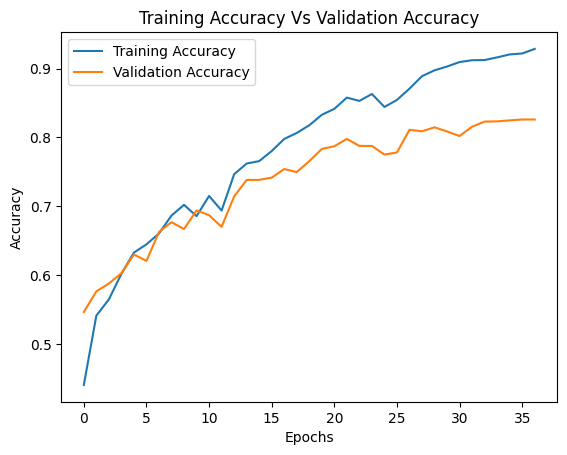

In [30]:
x_axis = list(range(len(history.history['accuracy'])))
plt.plot(x_axis, history.history['accuracy'], label = 'Training Accuracy')
plt.plot(x_axis, history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Training Accuracy Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

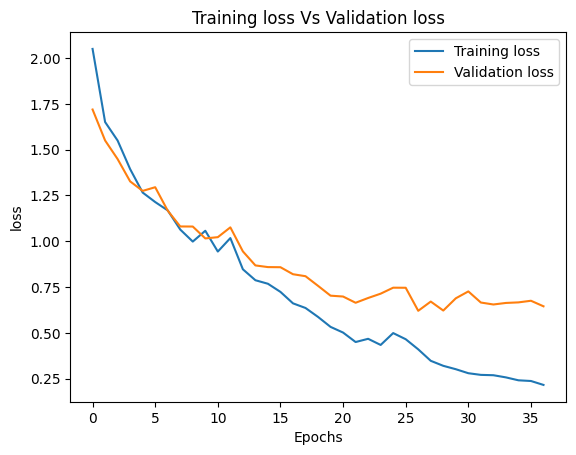

In [31]:
plt.plot(x_axis, history.history['loss'], label = 'Training loss')
plt.plot(x_axis, history.history['val_loss'], label = 'Validation loss')
plt.title('Training loss Vs Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### Show Samples from Testset

In [32]:
def plot_three_in_row(image1, image2, image3):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns
    
    # Plot 1
    axes[0].imshow(image1)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Plot 2
    axes[1].imshow(image2)
    axes[1].set_title('mask')
    axes[1].axis('off')
    
    # Plot 3
    axes[2].imshow(image3)
    axes[2].set_title('predicted')
    axes[2].axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [33]:
Xs, ys = next(val_generator_fn())
preds = model.predict(Xs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


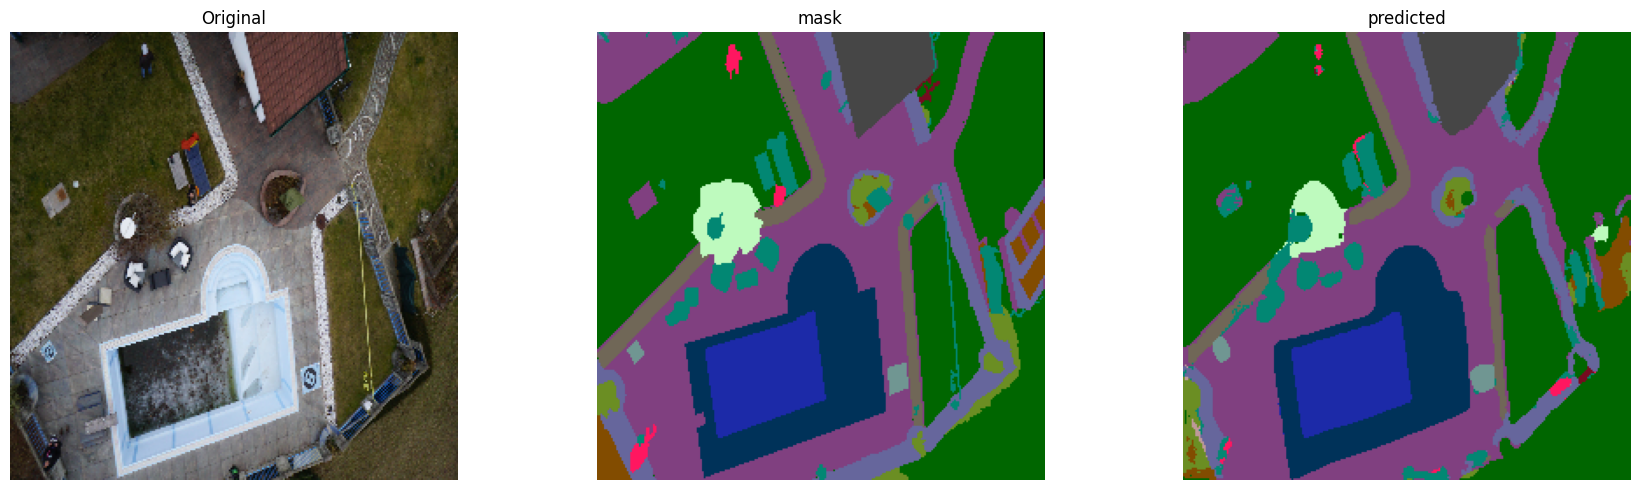

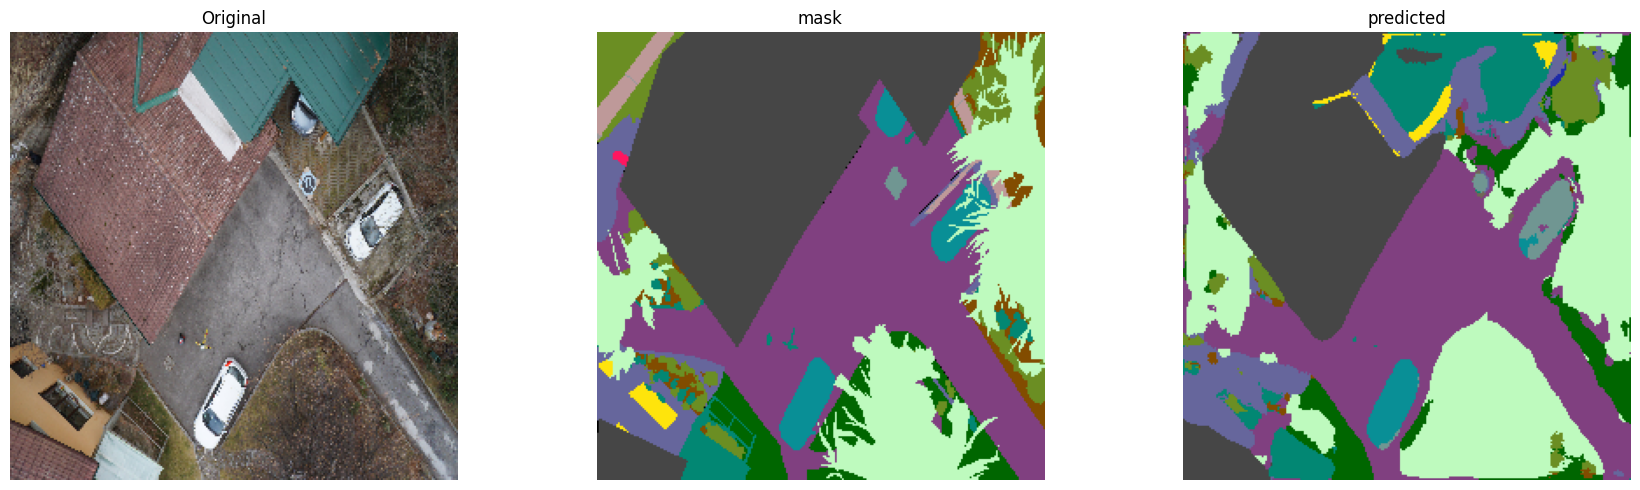

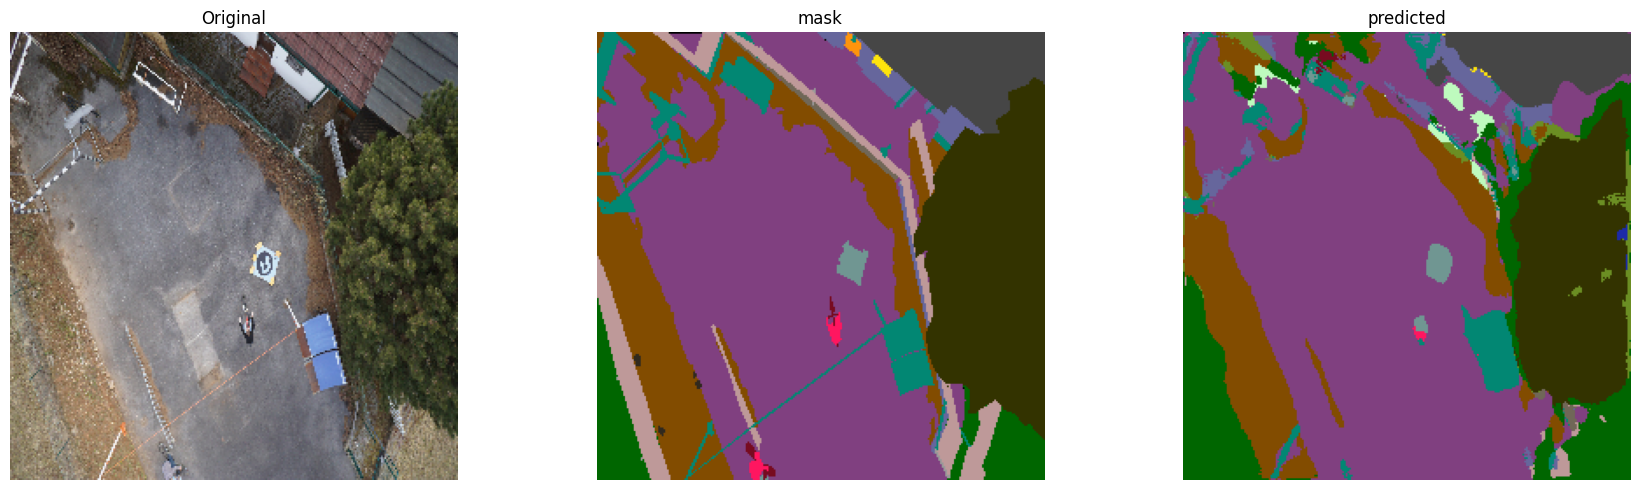

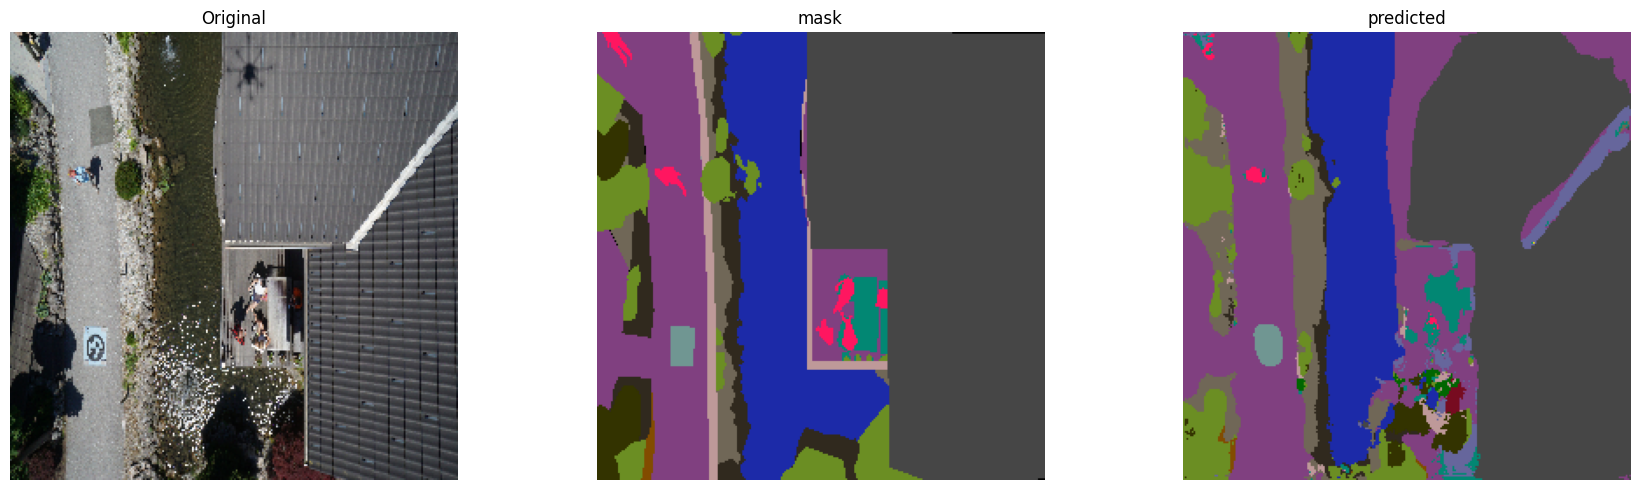

In [34]:
for X, y, pred in zip(Xs, ys, preds):
    pred = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(pred, axis=-1), -1))
    y = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(y, axis=-1), -1))
    plot_three_in_row(X, y, pred)